In [1]:
import pandas as pd
import numpy as np
import math
from random import choices
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import statistics

In [2]:
import devanalyst.simulation.statics as S_
import devanalyst.simulation.GenerateTimecards as timecard
from devanalyst.simulation.GenerateTimecards import WorkAssignments
from devanalyst.simulation.simulationModels import BalancedAllocationModel, GreedyAllocationModel, ModelsConfig, DefaultCostModel

importing Jupyter notebook from c:\alex\code\labs\devanalyst\devanalyst\simulation\statics.ipynb
importing Jupyter notebook from c:\alex\code\labs\devanalyst\devanalyst\simulation\GenerateTimecards.ipynb
importing Jupyter notebook from c:\alex\code\labs\devanalyst\devanalyst\simulation\simulationModels.ipynb


In [3]:
import devanalyst.simulation.tests.test_utils as tu_

importing Jupyter notebook from c:\alex\code\labs\devanalyst\devanalyst\simulation\tests\test_utils.ipynb


<h1>Pilots</h1>

<h2>Picking work to do - Pilot</h2>

In [ ]:
def dist_to_sample(distribution):
    sample = []
    for key in distribution:
        for i in range(int(distribution[key])):
            sample.append(key)
    return sample

In [ ]:
def addToDist(pick, dist):
    for k in pick.keys():
        val = pick[k]
        if k in dist.keys():
            dist[k] += val
        else:
            dist[k] = val            

In [ ]:
def removeFromDist(pick, dist):
    for k in pick.keys():
        val = pick[k]
        if k in dist.keys():
            dist[k] -= val
        else:
            dist[k] = -val

In [ ]:
# -uiModel: a dict
def _buildUIModelHelper(uiModel, title, snapshot, targetDist, snapshotDist, model, sprintDuration, row, column, color):

    data = dist_to_sample(snapshotDist)
    distance = model._measureDistributionDistance(targetDist, snapshotDist)    
    if len(data)==0:
        mean = 0
    else:
        mean = statistics.mean(data)
        
    uiModel['Title'].append(title)
    uiModel['Snapshot'].append(snapshot)
    uiModel['Size'].append(len(data))
    uiModel['Mean'].append(mean)
    uiModel['Distance'].append(distance)
    uiModel['Data'].append(data)
    uiModel['Color'].append(color)
    uiModel['Bins'].append(sprintDuration)

def _buildUIModel(title, snapshotPrefix, targetDist, sprintDuration, rows_nb, cols_nb):
       
    columns = ['Title', 'Snapshot', 'Size', 'Mean', 'Distance', 'Data', 'Color', 'Bins']
    uiModel = {}
    uiModel['Title'] = []
    uiModel['Snapshot'] = []
    uiModel['Size'] = []
    uiModel['Mean'] = []
    uiModel['Distance'] = []
    uiModel['Data'] = []
    uiModel['Color'] = []
    uiModel['Bins'] = []
    
    runningDist = {}
    remainingDist = targetDist.copy()

    # Configure models
    model = BalancedAllocationModel(sprintDuration) 
    modelsConfig = ModelsConfig([], [], model)
    modelsConfig.random.reset(271)
    
    _buildUIModelHelper(uiModel, title, 'Target', targetDist, targetDist, model, sprintDuration, 0, 0, 'g') 
                        
    snapshotCount = 0
    for row in range(rows_nb):
        for col in range(cols_nb):
            if (row == 0 and col == 0): # We already processed this - its the chart dedicated to 'Target'
                continue
            snapshotCount += 1
            pick = {}
            pick[model._pickOne(runningDist, remainingDist, targetDist, modelsConfig)] = 1    
            addToDist(pick, runningDist)
            _buildUIModelHelper(uiModel, title, snapshotPrefix + ' ' + str(snapshotCount), \
                            targetDist, runningDist, model, sprintDuration, row, col, 'b') 
            removeFromDist(pick, remainingDist)
        
    uiModel_df = pd.DataFrame(uiModel, columns=columns)   
    return uiModel_df

In [ ]:
def _coords(idx):
# Maps a linear index to the 2-dimensional coordinates assuming 4 columns.
# So it maps 0,1,2,3,4,5,6,7,.... to (0,0), (0,1), (0,2), (0,3), (1,0), (1,1), (1,2), (1,3), (2,0), ...
    row_nb = int((idx)/4)
    col_nb = idx - 4*row_nb
    return row_nb, col_nb
    
def renderUIModel(uiModel_df):
    
    last_row, last_col = _coords(uiModel_df.index.size-1)
    
    cols_nb = last_col + 1
    rows_nb = last_row + 1

    fig, axs = plt.subplots(rows_nb, cols_nb) 
    
    label = uiModel_df.iloc[0]['Title']

    fig.suptitle('---------------------------------------------  '+ str(label) + 
                 ' ---------------------------------------------', fontsize=16, y=1.4, x=1)

    for index, snapshot_info in uiModel_df.iterrows():
        row_nb, col_nb = _coords(index)
        data           = snapshot_info['Data']
        mean           = snapshot_info['Mean']
        distance       = snapshot_info['Distance']
        snapshot       = snapshot_info['Snapshot']
        color          = snapshot_info['Color']
        bins           = snapshot_info['Bins']
        size           = snapshot_info['Size']
        
        ax = axs[row_nb][col_nb]

        sns.distplot(data, bins=bins, color=color, ax=ax)
        ax.set_title(snapshot)
        ax.set_xlabel('size=' + str(size) + '; mean=' + str(round(mean, 2)) + '; distance=' + str(round(distance,2)))
        
    plt.subplots_adjust(top=1.2, right=2.3, wspace=0.3, hspace=1.0)

In [ ]:
target = {1:2, 2: 4, 3: 7, 4: 9, 5: 10, 6: 9, 7: 7, 8: 4, 9: 2, 10: 1}
ui_df = _buildUIModel('Empty Label', 'Pick', target, 10, 3, 4)
ui_df

In [ ]:
renderUIModel(ui_df)

<h2>Allocation across full release cycle - Pilot</h2>

In [4]:
def getPlans(work):
    unassigned = work.allocations[S_.UNPLANNED][S_.OWNER_TBD]
    unplanned = []
    unplanned.extend(unassigned[S_.BUGS_ON_COMPLETED_STORIES])
    unplanned.extend(unassigned[S_.BUGS_ON_UNFINISHED_STORIES])
    unplanned.extend(unassigned[S_.UNFINISHED_STORIES])
    
    planned_CURRENT_SPRINT = []
    subwork = work.allocations[S_.CURRENT_SPRINT]
    for person in subwork.keys():
        planned_CURRENT_SPRINT.extend(subwork[person][S_.BUGS_ON_COMPLETED_STORIES])
        planned_CURRENT_SPRINT.extend(subwork[person][S_.BUGS_ON_UNFINISHED_STORIES])
        planned_CURRENT_SPRINT.extend(subwork[person][S_.UNFINISHED_STORIES])

    planned_NEXT_SPRINT = []
    subwork = work.allocations[S_.NEXT_SPRINT]
    for person in subwork.keys():
        planned_NEXT_SPRINT.extend(subwork[person][S_.BUGS_ON_COMPLETED_STORIES])
        planned_NEXT_SPRINT.extend(subwork[person][S_.BUGS_ON_UNFINISHED_STORIES])
        planned_NEXT_SPRINT.extend(subwork[person][S_.UNFINISHED_STORIES])

            
    return planned_CURRENT_SPRINT, planned_NEXT_SPRINT, unplanned

In [7]:
def captureReleasePlans():    
# Run a release cycle and capture all the plans at the start and end of each sprint
    output = {}

    SPRINT_DURATION = 10
    NUMBER_OF_SPRINTS = 15
    EXTRA_SPRINTS_BUFFER = 5 # Buffer to finish up work that didn't fit into the intended number of sprints
    RELEASE_DURATION = SPRINT_DURATION * NUMBER_OF_SPRINTS

    # Configure models
    model = GreedyAllocationModel(SPRINT_DURATION) 
    modelsConfig = ModelsConfig([], [], model)
    modelsConfig.random.reset(271)

    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = tu_.initTestData(tu_.DEV_DF, tu_.PM_DF, \
                                                                             RELEASE_DURATION, SPRINT_DURATION, modelsConfig)
    # Select a team
    teamId = teams_df['Scrum Team'][0].teamId

    # Go through the sprints
    for n in range(NUMBER_OF_SPRINTS + EXTRA_SPRINTS_BUFFER):
        sprint = n+1
        output[sprint] = {}
        
        work = WorkAssignments(teamId, teamsRepo, storiesRepo, sprint) 
        
        #Debugging
        if (sprint==1):
            committed_df = work.committedTime(SPRINT_DURATION)
            tasks_df = work.committedTasks()

        planned_start_CURRENT_SPRINT, planned_start_NEXT_SPRINT, unplanned_start = getPlans(work)
        output[sprint]['planned_start_CURRENT_SPRINT'] = planned_start_CURRENT_SPRINT
        output[sprint]['planned_start_NEXT_SPRINT'] = planned_start_NEXT_SPRINT
        output[sprint]['unplanned_start'] = unplanned_start

        work = timecard.chooseWhatToDoInSprint(teamId, teamsRepo, storiesRepo, SPRINT_DURATION, modelsConfig, sprint)           
        timecard.deliverSprint(teamId, teamsRepo, ticketsRepo, storiesRepo, work, SPRINT_DURATION, modelsConfig) # mutates 'work'
        inflow = timecard.inflowOfTickets(teamId, teamsRepo, ticketsRepo, storiesRepo)
        timecard.updateBacklogAfterSprint(teamId, teamsRepo, ticketsRepo, storiesRepo, work, inflow) # Does not mutate 'work'
    
        planned_end_CURRENT_SPRINT, planned_end_NEXT_SPRINT, unplanned_end = getPlans(work)
        output[sprint]['planned_end_CURRENT_SPRINT'] = planned_end_CURRENT_SPRINT
        output[sprint]['planned_end_NEXT_SPRINT'] = planned_end_NEXT_SPRINT
        output[sprint]['unplanned_end'] = unplanned_end
    
    return output, committed_df, tasks_df, teamsRepo, storiesRepo, modelsConfig
plans, c1, t1, TEAMS_REPO, STORIES_REPO, MODELS_CONFIG = captureReleasePlans()

In [8]:
def _buildDistribution(snapshot, model):
    distribution = {}
    for e in snapshot:
        x = model._getBin(e)                       
        if x in distribution:
            distribution[x] = distribution[x] + 1
        else:
            distribution[x] = 1                
    return distribution    

def _calcSnapshotDistance(snapshot1, snapshot2, model):
    return model._measureDistributionDistance(_buildDistribution(snapshot1, model), \
                                             _buildDistribution(snapshot2, model))

In [9]:
def _plotPlansHelper(sprint, releasePlans, sprintDuration, figure, snapshot, ax, color):

    #ax = figure.add_subplot(2,3,ax_idx)
    
    data = []
    target = []
    if sprint -1 < len(releasePlans): # sprints start at 1, 2, 3, ... wheras len(releasePlans) goes 0, 1, 2, ..., 
        for item in releasePlans[sprint][snapshot]:
            data.append(item.estimate)
        for item in releasePlans[sprint]['unplanned_start']:
            target.append(item.estimate)
            
    sns.distplot(data, bins=sprintDuration, color=color, ax=ax)
    #ax1.legend(loc ='best')
    ax.set_title(snapshot)
    if len(data)==0:
        mean = 0
    else:
        mean = statistics.mean(data)
        
    model = BalancedAllocationModel(sprintDuration)

    
    distance = _calcSnapshotDistance(data, target, model)
    
    ax.set_xlabel('size=' + str(len(data)) + '; mean=' + str(round(mean, 2)) + '; distance=' + str(round(distance,2)))
    
def plotPlans(sprint, releasePlans, sprintDuration):
    #fig = plt.figure()

    fig, axs = plt.subplots(2, 3)   

    fig.suptitle('--------------------------------------------- SPRINT '+ str(sprint) + 
                 ' ---------------------------------------------', fontsize=16, y=1.4, x=1)

    _plotPlansHelper(sprint, releasePlans, sprintDuration, fig, 'unplanned_start', axs[0][0], 'g')
    _plotPlansHelper(sprint, releasePlans, sprintDuration, fig, 'planned_start_CURRENT_SPRINT', axs[0][1], 'b')
    _plotPlansHelper(sprint, releasePlans, sprintDuration, fig, 'planned_start_NEXT_SPRINT', axs[0][2], 'b')
    _plotPlansHelper(sprint, releasePlans, sprintDuration, fig, 'unplanned_end', axs[1][0], 'g')
    _plotPlansHelper(sprint, releasePlans, sprintDuration, fig, 'planned_end_CURRENT_SPRINT', axs[1][1], 'b')
    _plotPlansHelper(sprint, releasePlans, sprintDuration, fig, 'planned_end_NEXT_SPRINT', axs[1][2], 'b')
    
    plt.subplots_adjust(top=1.2, right=2.3, wspace=0.3, hspace=0.5)

C:\Alex\CodeImages\technos\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Alex\CodeImages\technos\anaconda3\lib\site-packages\numpy\lib\histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


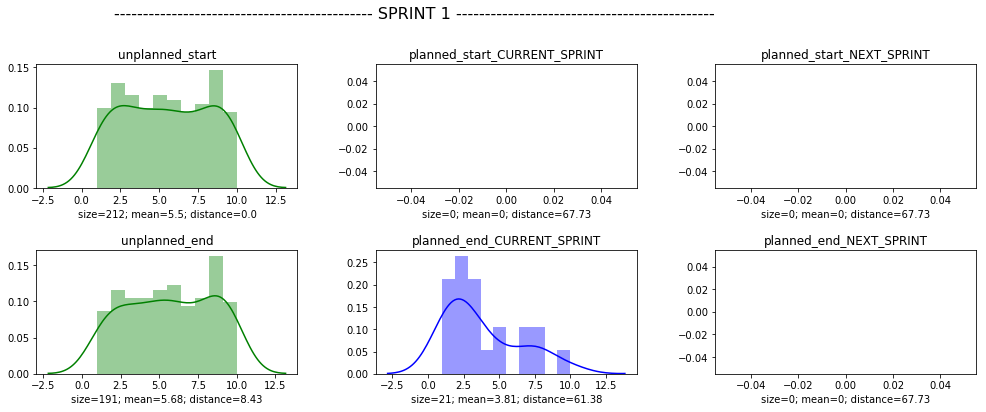

In [10]:
plotPlans(1, plans, 10)

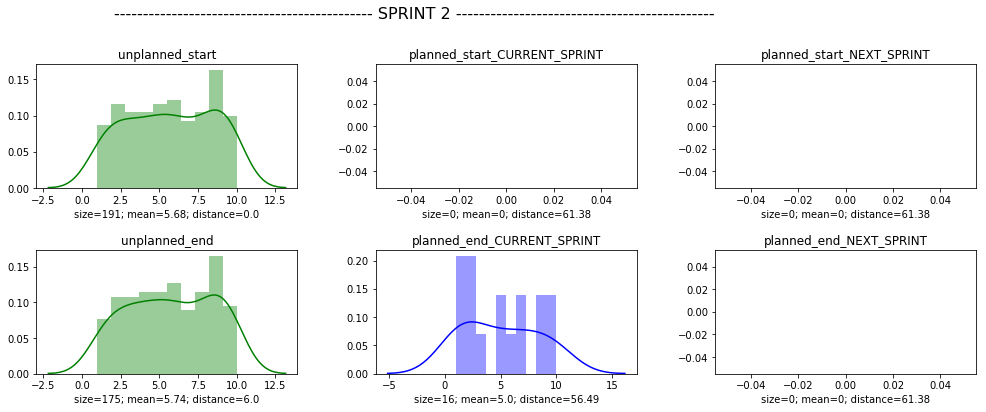

In [11]:
plotPlans(2, plans, 10)

In [ ]:
plotPlans(3, plans, 10)

In [ ]:
plotPlans(4, plans, 10)

In [ ]:
plotPlans(5, plans, 10)

In [ ]:
plotPlans(6, plans, 10)

In [ ]:
plotPlans(7, plans, 10)

In [ ]:
plotPlans(8, plans, 10)

In [ ]:
plotPlans(9, plans, 10)

In [ ]:
plotPlans(10, plans, 10)

In [ ]:
plotPlans(11, plans, 10)

In [ ]:
plotPlans(12, plans, 10)

In [ ]:
plotPlans(13, plans, 10)

In [ ]:
plotPlans(14, plans, 10)

In [ ]:
plotPlans(15, plans, 10)

In [ ]:
plotPlans(16, plans, 10)

In [ ]:
plotPlans(17, plans, 10)

<h2>Burnout in release cycle - Pilot</h2>

In [ ]:
# 
def genReleaseCycle(modelsConfig):
    RELEASE_DURATION = 60
    SPRINT_DURATION = 10
    
    tu_.loadTestResources()
    
    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = tu_.initTestData(tu_.DEV_DF, \
                                                                                           tu_.PM_DF, \
                                                                                           RELEASE_DURATION, \
                                                                                           SPRINT_DURATION, \
                                                                                          modelsConfig)
    
    NUMBER_OF_SPRINTS = 25

    entries_df, worksheets = timecard.runReleaseCycle(teamsRepo, ticketsRepo, storiesRepo, datetime(2018, 1, 15), \
                                                   SPRINT_DURATION, NUMBER_OF_SPRINTS, modelsConfig)    
    
    return entries_df, worksheets, storiesRepo

In [ ]:
def genBurnout(entries_df, storiesRepo):
    bystory = entries_df.groupby('User Story')
    u = bystory.apply(storyInfo, storiesRepo)
    
    
    u = u.reset_index()
    u.drop(['level_1'], axis='columns', inplace=True)
    s = u.groupby('Final Sprint')
    burnout = s.apply(sprintInfo)
    burnout = burnout.reset_index()
    burnout.drop(['level_1'], axis='columns', inplace=True)
    

    return burnout, u

In [ ]:
def storyInfo(group_df, storiesRepo):
    info = {}
    
    #Go back, as min['Date'] is end of first sprint
    info['Start'] = [timecard.subtractBusinessDays(group_df['Date'].min(), SPRINT_DURATION)] 
    info['End'] = [group_df['Date'].max()]
    info['Elapsed Time'] = (info['End'][0] - info['Start'][0]).days
    info['Effort'] = group_df['Time Spent'].sum()
    info['Initial Sprint'] = [group_df['Sprint'].min()]
    info['Final Sprint'] = [group_df['Sprint'].max()]  
    '''
    userStoryId = group_df['User Story']
    userStory = storiesRepo.findStory(userStoryId)
    info['Original estimate'] = userStory.originalEstimate    
    '''
    
    return pd.DataFrame(info)

In [ ]:
def sprintInfo(group_df):
    info = {}
    
    info['Effort'] = group_df['Effort'].sum()
    info['Avg Effort'] = group_df['Effort'].mean()
    info['Stories Completed'] = [group_df['User Story'].count()]
    info['Over 1 sprint'] = [group_df[group_df['Elapsed Time']==14]['User Story'].count()]
    info['Over 2 sprint'] = [group_df[group_df['Elapsed Time']==28]['User Story'].count()]
    info['Over 3 sprint'] = [group_df[group_df['Elapsed Time']==42]['User Story'].count()]
    info['Over 4 sprint'] = [group_df[group_df['Elapsed Time']==56]['User Story'].count()]
 
    
    return pd.DataFrame(info)

In [ ]:
SPRINT_DURATION = 10
modelsConfig1 = ModelsConfig([DefaultCostModel(0.0)], [], BalancedAllocationModel(SPRINT_DURATION)) 
modelsConfig1.random.reset(271)
entries_df1, worksheets1, storiesRepo = genReleaseCycle(modelsConfig1)

In [ ]:
burn1, u1 = genBurnout(entries_df1, storiesRepo)
burn1

In [ ]:
u1

In [ ]:
SPRINT_DURATION = 10
modelsConfig2 = ModelsConfig([DefaultCostModel(0.0)], [], GreedyAllocationModel(SPRINT_DURATION)) 
modelsConfig2.random.reset(271)
entries_df2, worksheets2, storiesRepo = genReleaseCycle(modelsConfig2)

In [ ]:
burn2, u2 = genBurnout(entries_df2, storiesRepo)
burn2

In [ ]:
burn1['Effort'].plot(label = 'Balanced'), burn2['Effort'].plot(label = 'Greedy'), plt.legend()

In [ ]:
burn1['Avg Effort'].plot(label = 'Balanced'), burn2['Avg Effort'].plot(label = 'Greedy'), plt.legend()

In [ ]:
u1_10 = u1[u1['Final Sprint'] == 10]
u1_10.shape

In [ ]:
u1_10[u1_10['Initial Sprint'] == 10]['Effort'].mean()

In [ ]:
u1_10['Effort'].mean()

In [ ]:
u1_10[u1_10['Initial Sprint'] == 10].shape

In [ ]:
u1_10[u1_10['Initial Sprint'] == 9]['Effort'].mean()

In [ ]:
u1_10[u1_10['Initial Sprint'] == 9].shape